In [ ]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"

dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)

dados.head()


,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [ ]:
# aqui os dados foram ordenados pela coluna vendido, assim separando os dados
# entre vendido e nao vendido, é uma separação ruim, mas foi feita de propósito
# para criar a necessidade da validação cruzada

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

# dummy é um modelo que me da um valor de base para comparar com os nossos modelos
modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

# com o dummy gerado, eu quero um algoritmo mais inteligente para ter uma outra
# base line
# max_depth=2 é o tanto de decissão ou o tanto de camadas a avore vai ter
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [ ]:
# gerando dados aleatórios de modelo de carro para simulação de agrupamento ao usar nosso estimador
# criando o modelo de carro, mas o modelo é uma variável categórica
np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [ ]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [ ]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


In [ ]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

# na validação cruzada a gente treinou n vezes o modelo para ter uma estimativa o quão bem
# esse modelo vai se dar bem no mundo real
pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


In [ ]:
!pip install graphviz==0.9
!pip install pydot

!apt-get install grapviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package grapviz


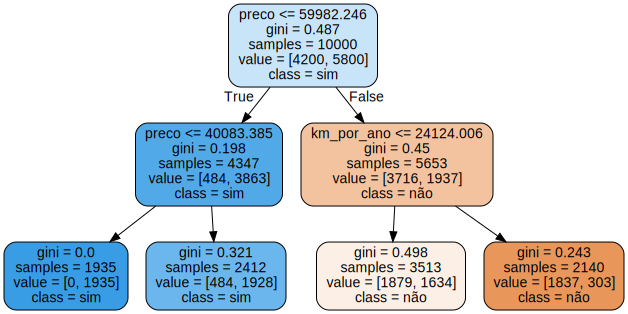

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# depois de treinar n vezes o modelo na validação cruzada, a gente pega e faz
# um unico treino com todos os dados que foram usados na validação cruzadas
modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, 
                class_names=["não", "sim"], 
                feature_names =  features)

graph = graphviz.Source(dot_data)
graph

In [ ]:
from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
# a escolha do max_depth influencia o quão bem vai rodar o algoritmo
# e nem quanto mais é melhor 
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.67
Intervalo [76.40, 80.94]


Os hiper parâmetros são declarados antes do treino, um bom exemplo é o max_depth do algoritmo da arvore de decisão, que é a profundidade maxima de uma arvore

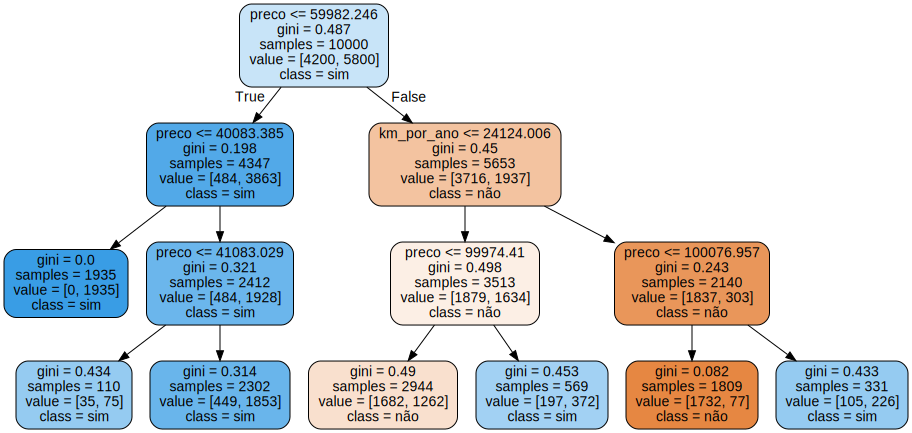

In [ ]:
modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, 
                class_names=["não", "sim"], 
                feature_names =  features)

graph = graphviz.Source(dot_data)
graph

In [ ]:
# rodando a arvore de decissão varias vezes para escolher qual é o melhor numero para definir o máximo de profundidade
from sklearn.model_selection import GroupKFold

def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
  print("max_depth = %d, media =%.2f" % (max_depth, results['test_score'].mean() * 100))



for i in range (1, 33):
      roda_arvore_de_decisao(i)

# quanto mais camadas a nossa arvore tem, menor é a média do resultado, mas era pra ser
# ao contrario, já que o algoritmo tem mais decissão para tomar, então a decissão final
# de vender ou não o carro, tinha que ser mais precisa. Mas isso tudo é nos dados de treino
# pois quanto mais o meu algoritmo treina com os mesmo dados, mais ele aprende sobre esses dados
# só que se ele encontra novos dados, ele acaba tendo um desempenho muito menor que no treino
# pois ele ta viciado só nos dados de treino

max_depth = 1, media =75.78
max_depth = 2, media =75.78
max_depth = 3, media =78.67
max_depth = 4, media =78.63
max_depth = 5, media =78.56
max_depth = 6, media =78.12
max_depth = 7, media =77.96
max_depth = 8, media =77.86
max_depth = 9, media =77.38
max_depth = 10, media =77.19
max_depth = 11, media =76.97
max_depth = 12, media =76.49
max_depth = 13, media =75.81
max_depth = 14, media =75.66
max_depth = 15, media =75.16
max_depth = 16, media =75.11
max_depth = 17, media =74.74
max_depth = 18, media =74.33
max_depth = 19, media =74.34
max_depth = 20, media =74.22
max_depth = 21, media =73.80
max_depth = 22, media =73.81
max_depth = 23, media =73.38
max_depth = 24, media =73.43
max_depth = 25, media =73.14
max_depth = 26, media =73.04
max_depth = 27, media =72.91
max_depth = 28, media =72.66
max_depth = 29, media =72.73
max_depth = 30, media =72.81
max_depth = 31, media =72.86
max_depth = 32, media =72.52


In [ ]:
# imprimindo a média de treino, como da pra ver o algoritmo sempre melhora
# com os dados de treino quanto mais vai afundando nas ramificações, mas ela
# fica melhor só para os dados de treino e fica cada vez pior para os dados de 
# treino.
from sklearn.model_selection import GroupKFold

def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  print("Arvore max_depth = %d, treino = %.2f, teste = %.2f," % (max_depth, results['train_score'].mean() * 100, results['test_score'].mean() * 100))



for i in range (1, 33):
      roda_arvore_de_decisao(i)

Arvore max_depth = 1, treino = 75.79, teste = 75.78,
Arvore max_depth = 2, treino = 75.79, teste = 75.78,
Arvore max_depth = 3, treino = 78.75, teste = 78.67,
Arvore max_depth = 4, treino = 78.79, teste = 78.63,
Arvore max_depth = 5, treino = 78.94, teste = 78.56,
Arvore max_depth = 6, treino = 79.17, teste = 78.12,
Arvore max_depth = 7, treino = 79.50, teste = 77.96,
Arvore max_depth = 8, treino = 79.89, teste = 77.86,
Arvore max_depth = 9, treino = 80.46, teste = 77.38,
Arvore max_depth = 10, treino = 81.16, teste = 77.19,
Arvore max_depth = 11, treino = 82.03, teste = 76.97,
Arvore max_depth = 12, treino = 82.89, teste = 76.49,
Arvore max_depth = 13, treino = 83.95, teste = 75.81,
Arvore max_depth = 14, treino = 85.03, teste = 75.66,
Arvore max_depth = 15, treino = 86.14, teste = 75.16,
Arvore max_depth = 16, treino = 87.19, teste = 75.11,
Arvore max_depth = 17, treino = 88.31, teste = 74.74,
Arvore max_depth = 18, treino = 89.26, teste = 74.33,
Arvore max_depth = 19, treino = 90.32

In [ ]:
from sklearn.model_selection import GroupKFold

def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("Arvore max_depth = %d, treino = %.2f, teste = %.2f" % (max_depth, results['train_score'].mean() * 100, results['test_score'].mean() * 100))
  # criando uma variável para isolar a tabela
  tabela = [max_depth, train_score, test_score]
  return tabela

resultados = [roda_arvore_de_decisao(i) for i in range (1, 33)]
resultados = pd.DataFrame(resultados, columns = ["max_depth", "train", "test"])
resultados.head()


Arvore max_depth = 1, treino = 75.79, teste = 75.78
Arvore max_depth = 2, treino = 75.79, teste = 75.78
Arvore max_depth = 3, treino = 78.75, teste = 78.67
Arvore max_depth = 4, treino = 78.79, teste = 78.63
Arvore max_depth = 5, treino = 78.94, teste = 78.56
Arvore max_depth = 6, treino = 79.17, teste = 78.12
Arvore max_depth = 7, treino = 79.50, teste = 77.96
Arvore max_depth = 8, treino = 79.89, teste = 77.86
Arvore max_depth = 9, treino = 80.46, teste = 77.38
Arvore max_depth = 10, treino = 81.16, teste = 77.19
Arvore max_depth = 11, treino = 82.03, teste = 76.97
Arvore max_depth = 12, treino = 82.89, teste = 76.49
Arvore max_depth = 13, treino = 83.95, teste = 75.81
Arvore max_depth = 14, treino = 85.03, teste = 75.66
Arvore max_depth = 15, treino = 86.14, teste = 75.16
Arvore max_depth = 16, treino = 87.19, teste = 75.11
Arvore max_depth = 17, treino = 88.31, teste = 74.74
Arvore max_depth = 18, treino = 89.26, teste = 74.33
Arvore max_depth = 19, treino = 90.32, teste = 74.34
Ar

,max_depth,train,test
0,1,75.791169,75.784219
1,2,75.791169,75.784219
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912


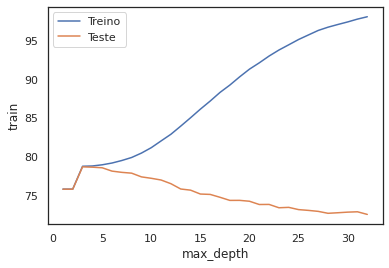

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# plotando um gráfico pra entender melhor a diferença entre os dados de treino
# e teste com o algoritmo, como da para ver, a media de dados do teste fica pior
# e os dados de treino fica melhor, pois ele treina muito para os dados de treino
# e não sabe oq fazer com os dados de teste
# então o treino ficou tão bom que gerou um overfit, muito treino e isso é ruim
sns.lineplot(x = "max_depth", y = "train", data = resultados)
sns.lineplot(x = "max_depth", y = "test", data = resultados)
plt.legend(["Treino", "Teste"])

In [ ]:
# aqui eu faço uma ordem decrescente para o teste, puxando qual foi a melhor media
# e buscando qual a melhor profundidade
resultados.sort_values("test", ascending=False).head()

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


In [ ]:
# no momento testamos com 1 hiper parâmetro, agora se tivermos 2 hiperparamentros
# temos que multiplicar o maximo de cada um entre eles e ai temos o resultado total
# de quantos testes iremos fazer, exemplo se o primeiro hiper tem 64 teste e o
# seguntambem tem 64 teste, 64 X 64 = 4096, esse é o total de combinações para
# testar nossos dois hiperparametros

In [ ]:
# explorando o hiper parâmetros em 2 dimensões, pois vamos ter 2 parâmetros
# no exemplo estamos fazendo 32 X 32 = 1024

def roda_arvore_de_decisao(max_depth, min_samples_leaf):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  # max depth é a profundidade da arvore e o min_samples_leaf é o número minimo de elementos na folha
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("Arvore max_depth = %d, min_samples_leaf = %d, treino = %.2f, teste = %.2f" % (max_depth, min_samples_leaf, results['train_score'].mean() * 100, results['test_score'].mean() * 100))
  # criando uma variável para isolar a tabela
  tabela = [max_depth, min_samples_leaf, train_score, test_score]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1, 33):
    for min_samples_leaf in range(1, 33):
      tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
      resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns = ["max_depth", "min_samples_leaf", "train", "test"])
  return resultados

resultados = busca()
resultados.head()

In [ ]:
# se explorarmos o espaço inteiro, vai demorar demais, então vamos rodar pra
# números especificos, no exemplo é 32 X 4 = 128 pares de hiper parãmetros
def roda_arvore_de_decisao(max_depth, min_samples_leaf):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  # max depth é a profundidade da arvore e o min_samples_leaf é o número minimo de elementos na folha
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("Arvore max_depth = %d, min_samples_leaf = %d, treino = %.2f, teste = %.2f" % (max_depth, min_samples_leaf, results['train_score'].mean() * 100, results['test_score'].mean() * 100))
  # criando uma variável para isolar a tabela
  tabela = [max_depth, min_samples_leaf, train_score, test_score]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1, 33):
    for min_samples_leaf in [32, 64, 128, 256]:
      tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
      resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns = ["max_depth", "min_samples_leaf", "train", "test"])
  return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 3, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 64, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67
Arvore max_depth = 4, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Arvore max_depth = 

,max_depth,min_samples_leaf,train,test
0,1,32,75.791169,75.784219
1,1,64,75.791169,75.784219
2,1,128,75.791169,75.784219
3,1,256,75.791169,75.784219
4,2,32,75.791169,75.784219


In [ ]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
15,4,256,78.750993,78.672633
12,4,32,78.750993,78.672633
14,4,128,78.750993,78.672633
13,4,64,78.750993,78.672633
8,3,32,78.750993,78.672633


In [ ]:
# quanto maior a profundiade melhor? quanto maior o minimo de smaple na folha é melhor?
# sera que se eu tivesse escolhido outros valres, seria melhor?
# como testar tudo consome muito processamento, um jeito e horitarizar o processamento
# em varias maquinas, outro jeito é esse que testamos, escolher números especifico
# uma maneira que "NÃO É UMA GARANTIA" é procurar uma relação entre o resultado de treino e teste
# para os hiper parâmetros, então uma correlação
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,train,test
max_depth,1.000000e+00,-2.780775e-16,0.536705,-0.027675
min_samples_leaf,-2.780775e-16,1.000000e+00,-0.409676,0.349011
train,5.367048e-01,-4.096762e-01,1.000000,0.116466
test,-2.767507e-02,3.490111e-01,0.116466,1.000000


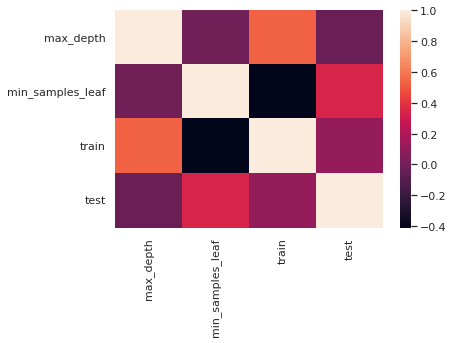

In [ ]:
# fazendo uma correlação com o mapa de calor, quanto mais clara a cor
# tem uma correlação forte positiva, quanto mais escuro a cor
# tem uma correlação forte negativa
sns.heatmap(corr)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8389d21090>,
      dtype=object)

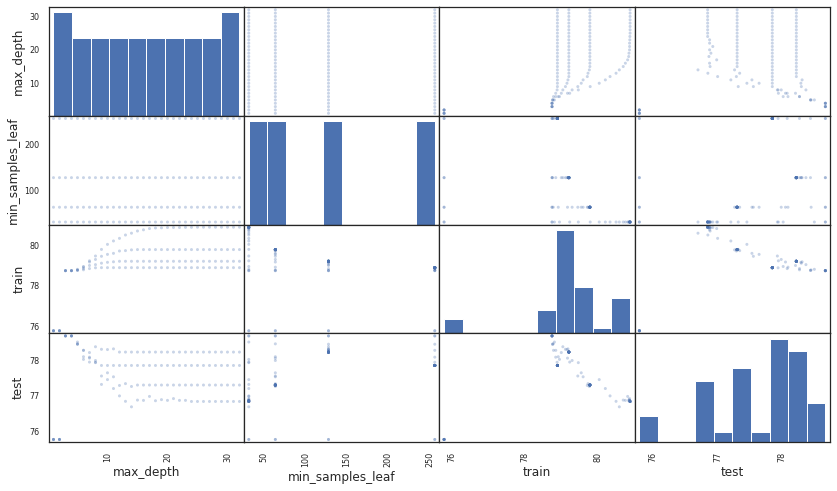

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(resultados, figsize = (14, 8), alpha = 0.3)

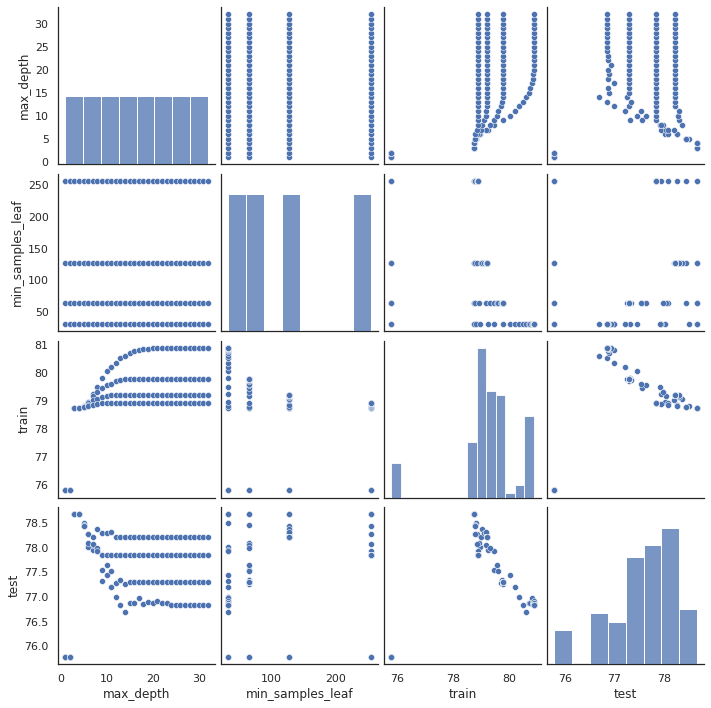

In [ ]:
sns.pairplot(resultados)
# essas linhas de dispersão é os valores especificos que passamos pro min_sample_leaf
# 32, 64, 128 e 256

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


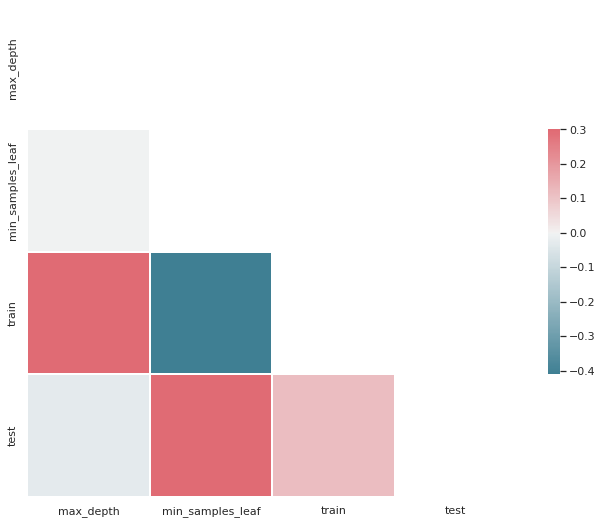

In [ ]:
# documentação do gráfico https://seaborn.pydata.org/examples/many_pairwise_correlations.html
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Gerar uma máscara para o triângulo superior
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# configurando o matplot
f, ax = plt.subplots(figsize=(11, 9))

# Gerar um mapa de cores divergente personalizado
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Desenhe o mapa de calor com a máscara e a proporção correta
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


# quanto maior é o min_sample_leaf, maior é a qualidade dos nossos teste

In [ ]:
# então sabemos que quanto maior o min_sample_leaf o teste melhora
# tiramos os dois valores mais baixo 32 e 64 e colocamos mais dois valores maiores
# para fazer um novo teste e ver se mantem essa correlação
# mas isso não garante que eu ache o melhor resultado, mas é uma maneira de achar.
def busca():
  resultados = []
  for max_depth in range(1, 33):
    for min_samples_leaf in [128, 192, 256, 512]:
      tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
      resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns = ["max_depth", "min_samples_leaf", "train", "test"])
  return resultados

resultados = busca()
resultados.head()

Arvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 192, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 1, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 192, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Arvore max_depth = 2, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Arvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 192, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67
Arvore max_depth = 3, min_samples_leaf = 512, treino = 77.53, teste = 77.50
Arvore max_depth = 4, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Arvore max_d

,max_depth,min_samples_leaf,train,test
0,1,128,75.791169,75.784219
1,1,192,75.791169,75.784219
2,1,256,75.791169,75.784219
3,1,512,75.791169,75.784219
4,2,128,75.791169,75.784219


In [ ]:
corr = resultados.corr()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


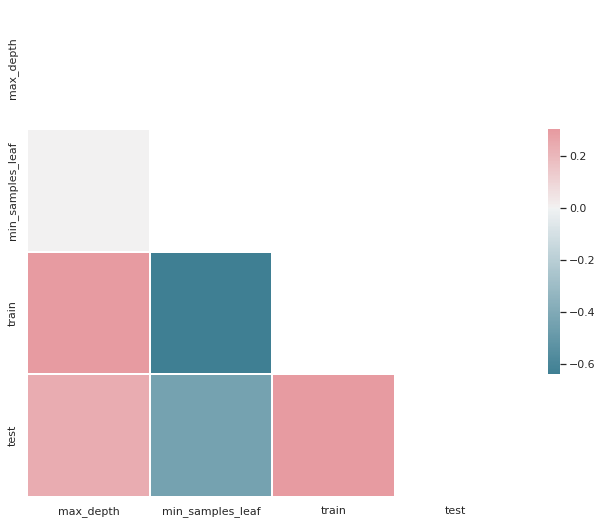

In [ ]:
sns.set(style="white")

# Gerar uma máscara para o triângulo superior
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# configurando o matplot
f, ax = plt.subplots(figsize=(11, 9))

# Gerar um mapa de cores divergente personalizado
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Desenhe o mapa de calor com a máscara e a proporção correta
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# agora deu uma correlação negativa

In [ ]:
resultados.sort_values("test", ascending=False).head()

,max_depth,min_samples_leaf,train,test
13,4,192,78.750993,78.672633
8,3,128,78.750993,78.672633
9,3,192,78.750993,78.672633
10,3,256,78.750993,78.672633
14,4,256,78.750993,78.672633


In [ ]:
# vamos testar com 3 hiper parâmetros
# o min_sample_split é as ramificações "os galhos", as partes antes da folha e após a raiz
# e esse hiper parâmetro fala o minimo de elemento que cada galho tem que ter
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  # rodando 10 vezes
  cv = GroupKFold(n_splits = 10)
  # max depth é a profundidade da arvore e o min_samples_leaf é o número minimo de elementos na folha
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  # pegando o tempo de execução
  fit_time = results['fit_time'].mean()
  score_time = results['score_time'].mean()

  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  # criando uma variável para isolar a tabela
  tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
  return tabela

# testando todas as combinações dos 3 hiper parâmetros.
# max_depth, min_samples_leaf e min_sample_split
# 32x4x4 = 512, 512x10 = 5200 split de treino e teste
def busca():
  resultados = []
  for max_depth in range(1, 33):
    for min_samples_leaf in [32, 64, 128, 256]:
      for min_samples_split in [32, 64, 128, 256]:
        tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
        resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns = ["max_depth", "min_samples_leaf", "min_samples_split", "train", "test", "fit_time", "score_time"])
  return resultados

resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791169,75.784219,0.006463,0.002003
1,1,32,64,75.791169,75.784219,0.006465,0.001995
2,1,32,128,75.791169,75.784219,0.006849,0.002335
3,1,32,256,75.791169,75.784219,0.006665,0.002279
4,1,64,32,75.791169,75.784219,0.006377,0.002144


In [ ]:
resultados.sort_values("test", ascending=False).head()


,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
63,4,256,256,78.750993,78.672633,0.027290,0.004422
48,4,32,32,78.750993,78.672633,0.015860,0.002574
34,3,32,128,78.750993,78.672633,0.011883,0.002319
35,3,32,256,78.750993,78.672633,0.012150,0.002509
36,3,64,32,78.750993,78.672633,0.014688,0.002959


In [ ]:
corr = resultados.corr()
corr

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
max_depth,1.000000e+00,1.300685e-16,4.182375e-16,0.529391,0.011529,0.343097,0.087672
min_samples_leaf,1.300685e-16,1.000000e+00,0.000000e+00,-0.341222,0.286555,-0.305741,0.008075
min_samples_split,4.182375e-16,0.000000e+00,1.000000e+00,-0.126171,0.132827,-0.062810,-0.009589
train,5.293913e-01,-3.412220e-01,-1.261715e-01,1.000000,0.247850,0.549680,0.117269
test,1.152853e-02,2.865546e-01,1.328271e-01,0.247850,1.000000,0.004838,0.112013
fit_time,3.430969e-01,-3.057410e-01,-6.280984e-02,0.549680,0.004838,1.000000,0.743820
score_time,8.767194e-02,8.074518e-03,-9.589302e-03,0.117269,0.112013,0.743820,1.000000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


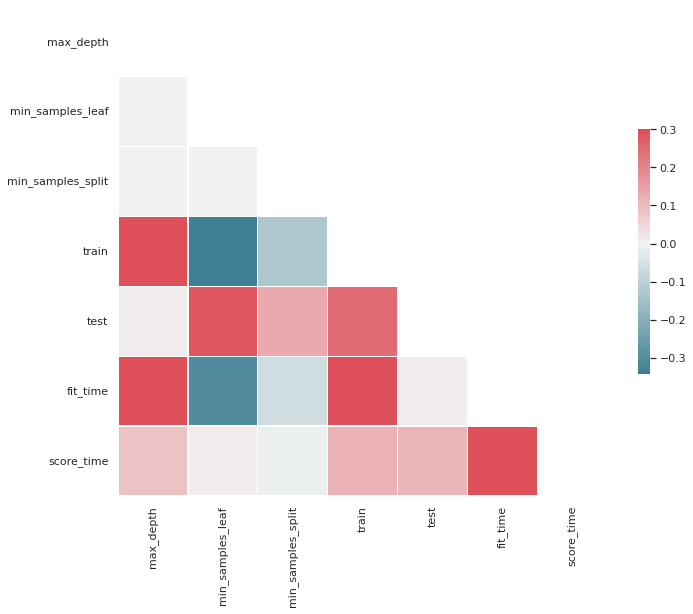

In [ ]:
sns.set(style="white")

# Gerar uma máscara para o triângulo superior
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# configurando o matplot
f, ax = plt.subplots(figsize=(11, 9))

# Gerar um mapa de cores divergente personalizado
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Desenhe o mapa de calor com a máscara e a proporção correta
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


as melhores circunstância para se usar hiperparâmetros é Quando queremos explorar espaço de dados em dimensões, onde podemos definir os parâmetros que gostaríamos para fazer testes.

In [ ]:
# fizemos um código muito grande para 3 parâmetros, mas e se tivermos mais?, 5,6, 7
# com escala diferentes, qualquer número entre 0 a 100 incluindo casas decimais
# então fica meio inviavel, mas o sklearn tem uma biblioteca que resolve esse problema

from sklearn.model_selection import GridSearchCV

SEED=301
np.random.seed(SEED)

# aqui eu declaro os hiper parametros e os valores, então o grid vai calcular
# todas as possibilidades.
espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                     # repetir 10x
                    cv = GroupKFold(n_splits = 10))

# ese fit vai rodar o cross validade
busca.fit(x_azar, y_azar,groups = dados.modelo)
# aqui me retorna um dicionario que da pra transformar em um df
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.012096,0.001313,0.002146,0.000087,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.011300,0.000215,0.002158,0.000251,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.011744,0.000958,0.002222,0.000327,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.011231,0.000360,0.002094,0.000130,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.011267,0.000462,0.002182,0.000314,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,...,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [ ]:
# buscando os melhores parametros
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


In [ ]:
# o melhor estimador
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

In [ ]:
from sklearn.metrics import accuracy_score 

# pegando o melhor modelo, quão bom ele vai se sair no mundo real
predicoes = melhor.predict(x_azar) 
accuracy = accuracy_score(predicoes, y_azar) * 100

print("Accuracy para os dados foi %.2f%%" % accuracy)
# 78%, o quão bom isso é no mundo real?
# bom pegamos o nosso melhor estimador e usamos uma vez em todos os dados
# mas durante os nossos teste, fizemos o cross validation
# então com a validação cruzada, devemos tomar alguns cuidados
# então se a gente está fazendo um grid com cross, não podemos fazer um predict
# mas sim um outro cross validation
# então evita a abordagem acima, pois é muito otimista e queremos uma abordagem realista

Accuracy para os dados foi 78.75%


In [ ]:
# Como ter uma estimativa sem esse vício nos dados que eu já ví
# no caso de cross validation com busca de hiper parâmetros, fazemos uma nova validação cruzada
from sklearn.model_selection import cross_val_score
                        #grid                   #cross com 10 split, repet 10x
scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=10), groups = dados.modelo)

# quando usamos cross validation aninhada, temos um bug, o groupkfold falha

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py", line 891, in fit
    self._run_search(evaluate_candidates)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py", line 1392, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                     # kfold normal
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010969,0.001553,0.002315,0.000251,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.010275,0.000402,0.002187,0.000027,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.011337,0.001356,0.002641,0.000473,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.010503,0.000339,0.002622,0.000264,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.010324,0.000204,0.002261,0.000054,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [ ]:
from sklearn.model_selection import cross_val_score
# agr usando o kfold normal
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.7895, 0.7825, 0.7905, 0.7715, 0.7995])

In [ ]:
def imprime_score(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [ ]:
imprime_score(scores)

Accuracy médio 78.67
Intervalo [76.80, 80.54]


In [ ]:
# o melhor estimador
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

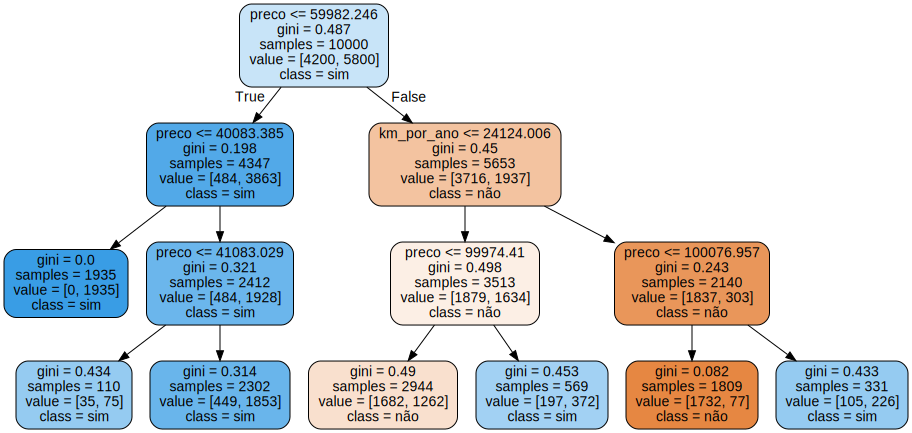

In [ ]:
from sklearn.tree import export_graphviz
import graphviz


features = x_azar.columns
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names=features)
graph = graphviz.Source(dot_data)
graph

In [ ]:
# como funciona o Nested cross validation?
# Ele é utilizado quando precisamos buscar hiperparâmetros para fazer uma nova validação.
# Com os hiperparâmetros nos colocamos os parâmetros que gostaríamos e fazemos a validação utilizando o neste cross validation